# Required Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


2023-04-17 21:53:06.562418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Download Dataset

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


# Load Dataset

In [3]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=3500,
  #color_mode='grayscale',
  labels=None
  )


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=170,
  #color_mode='grayscale',
  labels=None
  )


train_ds = train_ds.map(lambda x : (x,x))
val_ds = val_ds.map(lambda x : (x,x))


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), normalization_layer(y)))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), normalization_layer(y)))

Found 3670 files belonging to 1 classes.
Using 2936 files for training.


2023-04-17 21:53:13.452649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 3670 files belonging to 1 classes.
Using 734 files for validation.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Encoder

In [4]:
class Autoencoder(Model):
  
  def __init__(self, latent_dim):

    super(Autoencoder, self).__init__()

    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),   
    ])

    
    self.decoder = tf.keras.Sequential([
      layers.Dense(img_height*img_width*3, activation='sigmoid'),
      layers.Reshape((img_height, img_width, 3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Train Encoder

In [5]:
latent_dim = 64
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(train_ds,
                epochs=11,
                #shuffle=True,
                validation_data=val_ds)

autoencoder.encoder.summary()



Epoch 1/11


2023-04-17 21:53:18.357568: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1141516800 exceeds 10% of free system memory.
2023-04-17 21:53:18.565660: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1141516800 exceeds 10% of free system memory.
2023-04-17 21:53:18.565703: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1141516800 exceeds 10% of free system memory.
2023-04-17 21:53:20.116738: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1141516800 exceeds 10% of free system memory.
2023-04-17 21:53:21.103757: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1141516800 exceeds 10% of free system memory.


1/1 [==============================] - 12s 12s/step - loss: 0.0978 - val_loss: 0.0962
Epoch 2/11
1/1 [==============================] - 7s 7s/step - loss: 0.0978 - val_loss: 0.0961
Epoch 3/11
1/1 [==============================] - 7s 7s/step - loss: 0.0978 - val_loss: 0.0961
Epoch 4/11
1/1 [==============================] - 7s 7s/step - loss: 0.0978 - val_loss: 0.0961
Epoch 5/11
1/1 [==============================] - 7s 7s/step - loss: 0.0978 - val_loss: 0.0961
Epoch 6/11
1/1 [==============================] - 7s 7s/step - loss: 0.0978 - val_loss: 0.0961
Epoch 7/11
1/1 [==============================] - 7s 7s/step - loss: 0.0977 - val_loss: 0.0960
Epoch 8/11
1/1 [==============================] - 7s 7s/step - loss: 0.0977 - val_loss: 0.0960
Epoch 9/11
1/1 [==============================] - 7s 7s/step - loss: 0.0977 - val_loss: 0.0960
Epoch 10/11
1/1 [==============================] - 7s 7s/step - loss: 0.0977 - val_loss: 0.0960
Epoch 11/11
1/1 [==============================] - 7s 7s/s

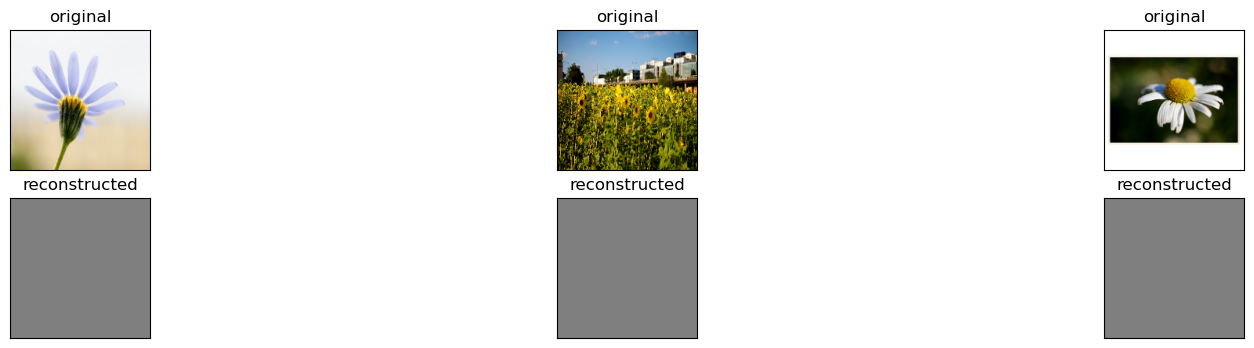

In [7]:
imagesList= []
for images, labels in val_ds.take(1):  # only take first element of dataset
    imagesList = images

encoded_imgs = autoencoder.encoder(imagesList).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 3
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(imagesList[i])
  plt.title("original")
  #plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  #plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
